# Sign Lenguage MNIST

**Universitario:** Pinto Barrón Osvaldo Dennis.

**Carrera:** Ingeniería en Diseño y Animación Digital.

**Temática del dataset:** Representación gráfica del lenguaje de señas americano, excluyendo las letras J y Z debido a los movimientos gestuales.

**Enlace del dataset:**  [Sign Language MNIST](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)

**Formato:** Está diseñado para coincidir estrechamente con el MNIST clásico. Cada caso de entrenamiento y prueba representa una etiqueta (0-24) como un mapa uno a uno para cada letra del alfabeto de la A a la Z (y no hay casos para 9=J o 25=Z debido a los movimientos gestuales).

El dataset se divide de la siguiente forma:


*   Datos de entrenamiento (27.455 casos).
*   Datos de prueba (7172 casos).



Columnas usadas para la realización de la clasificación:



*   **Variables de entrada:** Se usan 784 columnas, que tienen los pixeles de las imágenes a escala de grises con valores que van desde el 0 al 255.
*   **Variable de salida:**
Contiene la etiqueta que va del 0 al 24, representando una letra del abecedario (A-Z) a través del lenguaje de señas.






# Clasificación Multivariable (One vs All)
## Importación de librerías
Importación de archivos desde la nube de Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Librerías necesarias para el manejo de cálculo, manejo de datos, gráficas y optimización.

In [2]:
# utilizado para la manipulación de directorios y rutas
import os

# Cálculo científico y vectorial para python
import numpy as np

# Manejo de datos
import pandas as pd

# Libreria para graficos
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Modulo de optimizacion en scipy
from scipy import optimize

# le dice a matplotlib que incruste gráficos en el cuaderno
%matplotlib inline

## 1. Cargamos los datos
Los datos de entrenamiento del dataset **sign_mnist_train.csv** poseen 27.455 datos.


In [3]:
# Cargar el archivo CSV, especificando que hay un encabezado en la primera fila
data_original = pd.read_csv('/content/drive/MyDrive/Datasets/sign_mnist_train.csv')

# Imprimir las primeras filas del DataFrame para verificar
data_original.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### 1.1 Insertar atributos que contengan, caracteres, texto y valores booleanos.
+ **i % len(origins, difficulties):** Esto permite que el índice i se "reinicie" al llegar al final de la lista origins, asegurando que todos los valores se distribuyan uniformemente.

In [4]:
# Generar una lista de valores distribuidos uniformemente para cada atributo inventado
origins = ['ASL', 'BSL', 'ISL']
difficulties = ['easy', 'medium', 'hard']

# Crear los atributos inventados usando ciclos para alcanzar la longitud adecuada
data_original['Señal_origen'] = [origins[i % len(origins)] for i in range(len(data_original))]
data_original['Señal_comun'] = data_original['label'].apply(lambda x: x in [0, 1, 2, 3, 4])
data_original['Dificultad'] = [difficulties[i % len(difficulties)] for i in range(len(data_original))]

# Verificar la inserción correcta de los nuevos atributos
data_original.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,Señal_origen,Señal_comun,Dificultad
0,3,107,118,127,134,139,143,146,150,153,...,207,206,206,206,204,203,202,ASL,True,easy
1,6,155,157,156,156,156,157,156,158,158,...,87,94,163,175,103,135,149,BSL,False,medium
2,2,187,188,188,187,187,186,187,188,187,...,199,198,199,198,195,194,195,ISL,True,hard
3,2,211,211,212,212,211,210,211,210,210,...,231,230,226,225,222,229,163,ASL,True,easy
4,13,164,167,170,172,176,179,180,184,185,...,108,133,163,157,163,164,179,BSL,False,medium


### 1.2 Duplicación de ejemplos con pequeñas variaciones

Creamos una función para duplicar el dataset sintético. Es decir, tendremos 54.910 datos con pequeñas variaciones (0 a 5) en los valores de 0 a 255.

+ **X_dup:** Los datos modificados a partir del dataset original con pequeñas variaciones.
+ **y_dup:** Toma una copia de los valores originales de la etiqueta.
+ **np.vstack:** Combinas el dataset original (X_original) con el dataset variado (X_sintetico) para crear el dataset duplicado.

In [5]:
def duplicar_dataset(X, y, min_val = 0, max_val = 1):

    # Normalizar los datos originales
    X_norm = (X - X.min()) / (X.max() - X.min()) * (max_val - min_val) + min_val

    # Duplicar los datos originales
    X_dup = X_norm.copy()
    y_dup = y.copy()

    # Añadir pequeñas variaciones aleatorias a las imágenes
    noise = np.random.normal(0, 0.05, X.shape)  # Variaciones pequeñas
    X_dup = np.clip(X_dup + noise, 0, 255)  # Asegura valores válidos de píxeles

    # Convertir las variaciones a enteros
    #X_dup = np.round(X_dup).astype(int)

    # Concatenar dataset original con el duplicado
    X_synthetic = np.vstack((X, X_dup))
    y_synthetic = np.concatenate((y, y_dup))

    return X_synthetic, y_synthetic

Convertimos el dataset a un vector numpy.

**Importante:** Destacamos los atributos inventados por las siguientes razones:
+ **Compatibilidad con el Modelo:**Los atributos inventados, como los de texto o booleanos, no aportan directamente al proceso de clasificación basado en píxeles.

+ **Formato de Entrada para Numpy:** No son compatibles con las operaciones matemáticas realizadas en el entrenamiento de modelos de regresión logística, ya que estas operaciones esperan matrices numéricas.

+ **Enfoque en Características Relevantes:** Los atributos inventados se añadieron para enriquecer el contexto y complejidad del dataset, pero no son esenciales para el entrenamiento del modelo.

In [6]:
X_original = data_original.drop(['label', 'Señal_origen', 'Señal_comun', 'Dificultad'], axis=1).values / 255.0 # Normalización
y_original = data_original['label'].values

Llamamos a la función para duplicar los datos.

In [7]:
X_sintetico, y_sintetico = duplicar_dataset(X_original, y_original)

# Verificamos el tamaño
print(X_sintetico.shape)
print(y_sintetico.shape)

(54910, 784)
(54910,)


Comprobamos que haya una varación a partir del dato 27456.


In [8]:
print(X_original[:5])          # Muestra las primeras filas del dataset original
print(X_sintetico[27455:27460]) # Muestra filas después del punto de duplicación para verificar la variación

[[0.41960784 0.4627451  0.49803922 ... 0.8        0.79607843 0.79215686]
 [0.60784314 0.61568627 0.61176471 ... 0.40392157 0.52941176 0.58431373]
 [0.73333333 0.7372549  0.7372549  ... 0.76470588 0.76078431 0.76470588]
 [0.82745098 0.82745098 0.83137255 ... 0.87058824 0.89803922 0.63921569]
 [0.64313725 0.65490196 0.66666667 ... 0.63921569 0.64313725 0.70196078]]
[[0.38797601 0.47883498 0.39545043 ... 0.78144899 0.80830665 0.71172534]
 [0.56592616 0.5355554  0.52381226 ... 0.41274233 0.56869937 0.58681621]
 [0.666152   0.7337455  0.73921686 ... 0.76834023 0.78875984 0.81030323]
 [0.73561228 0.87638009 0.8911318  ... 0.77362772 0.93207913 0.63822294]
 [0.59424402 0.69247574 0.74273314 ... 0.63172465 0.67862105 0.76328502]]


### 1.3 Visualización de imágenes del dataset original y duplicado
Creamos una función para graficar 10 imágenes de forma randómica.

In [9]:
def plot_images(X, title, start_index=0):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle(title)
    indices = np.arange(start_index, start_index + 10) # Selecciona 10 imágenes a partir del start_index
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(X[indices[i]].reshape(28, 28), cmap='gray')
        ax.axis('off')
    plt.show()

Llamamos a la función

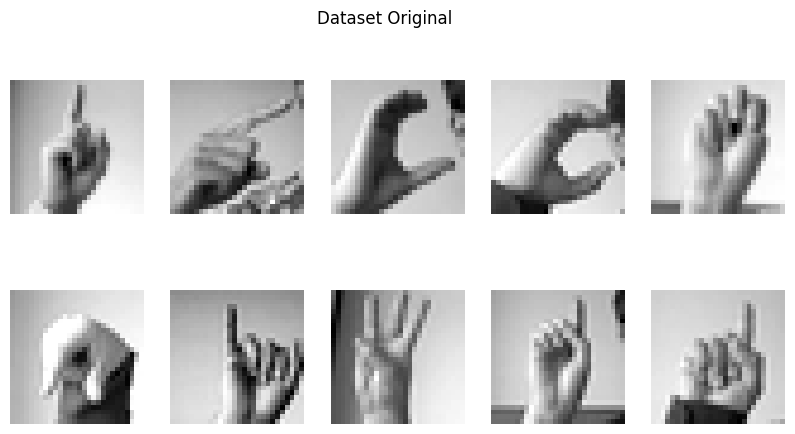

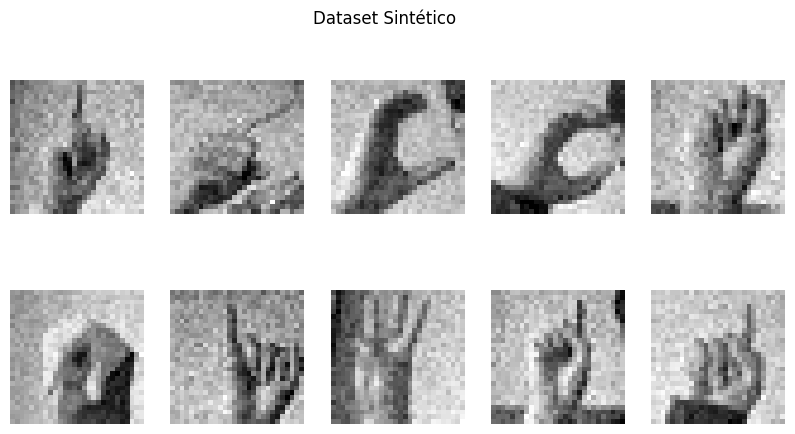

In [10]:
plot_images(X_original, 'Dataset Original')
plot_images(X_sintetico, 'Dataset Sintético', start_index=27455)

### 1.4 División en datos de entrenamiento y prueba

In [11]:
# Dividir los datos en entrenamiento (80%) y prueba (20%)
m = X_sintetico.shape[0]
train_size = int(m * 0.8)

X_train = X_sintetico[:train_size]
y_train = y_sintetico[:train_size]
X_test = X_sintetico[train_size:]
y_test = y_sintetico[train_size:]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(43928, 784)
(43928,)
(10982, 784)
(10982,)


### 1.5 Entrenar los modelos de regresión logística para cada clase

#### 1.5.1 Función sigmoide (z)

In [12]:
def sigmoid(z):

    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

#### 1.5.2 Función del costo y el gradiente

In [13]:
def lrCostFunction(theta, X, y, lambda_=0.1):
    m = y.size

    if y.dtype == bool:
        y = y.astype(int)

    J = 0
    h = sigmoid(X.dot(theta.T))

    # Evitar valores de h que sean 0 o 1
    epsilon = 1e-10
    h = np.clip(h, epsilon, 1 - epsilon)

    temp = theta.copy()
    temp[0] = 0

    J = (1 / m) * np.sum(-y.dot(np.log(h)) - (1 - y).dot(np.log(1 - h))) + (lambda_ / (2 * m)) * np.sum(np.square(temp))

    grad = (1 / m) * (h - y).dot(X) + (lambda_ / m) * temp

    return J, grad

#### 1.5.3 Función descenso por el Gradiente

In [14]:
def descensoGradiente(theta, X, y, alpha, num_iters, lambda_=0.1):
    # Inicializa algunos valores
    m = y.shape[0]  # Número de ejemplos de entrenamiento

    # Realiza una copia de theta, el cual será actualizada por el descenso por el gradiente
    theta = theta.copy()
    J_history = []

    for i in range(num_iters):
        # Calcula la hipótesis usando la función sigmoide
        h = sigmoid(X.dot(theta.T))  # Asegura que X.dot(theta) sea compatible con np.exp
        h = np.clip(h, 1e-15, 1 - 1e-15)  # Evitar valores extremos para la función de coste

        gradient = (1 / m) * X.T.dot(h - y)
        gradient[1:] = gradient[1:] + (lambda_ / m) * theta[1:]
        theta -= alpha * gradient

        # Calcula el costo con la función lrCostFunction (asegurando que solo se obtenga el costo)
        cost, _ = lrCostFunction(theta, X, y, lambda_)
        J_history.append(cost)

    return theta, J_history

#### 1.5.4 Entrenamiento

In [15]:
# Función para predecir los valores de la clase entrenada
def predict_binario(X, theta):
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # Añadir columna de unos
    prob = sigmoid(X.dot(theta.T))
    return (prob >= 0.5).astype(int)  # Convertir a 0 o 1

In [16]:
def entrenamiento_binario_por_clase(X, y, clase, alpha, num_iters, lambda_):
    m, n = X.shape
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Añadir columna de unos
    theta = np.zeros(X.shape[1])  # Inicialización de theta

    # Crear un vector binario para la clase específica (1 si pertenece a la clase, 0 si no)
    y_clase = (y == clase).astype(int)

    # Entrenamiento del modelo binario usando descenso por gradiente
    theta_binario, J_history_binario = descensoGradiente(theta, X, y_clase, alpha, num_iters, lambda_)

    # Retorna theta y el historial de costos
    return theta_binario, J_history_binario, y_clase

Almacenamos los costos de cada clase e imprimimos los costos finales.

In [17]:
# Tenemos 25 etiquetas (0-24)
num_labels = 25
n = X_train.shape[1] # Número de características
all_theta = np.zeros((num_labels, n))

alpha = 0.001 # tasa de aprendizaje
num_iters = 100 # número de iteraciones
lambda_ = 0.01 # parámetro de regularización

In [18]:
# Lista para almacenar los historiales de costos de cada clase
costos_por_clase = []

# Entrenamiento y predicción del modelo binario para cada clase
for clase in range(num_labels):
    theta_clase, J_history_binario, y_clase_entrenamiento = entrenamiento_binario_por_clase(X_train, y_train, clase, alpha, num_iters, lambda_)

    # Almacenar el historial de costos de esta clase
    costos_por_clase.append(J_history_binario)

    # Hacer predicciones en el conjunto de entrenamiento
    y_pred_entrenamiento = predict_binario(X_train, theta_clase)
    precision_entrenamiento = np.mean(y_pred_entrenamiento == y_clase_entrenamiento) * 100
    print(f"Precisión en el conjunto de entrenamiento para la clase {clase}: {precision_entrenamiento:.2f}%")

    # Mostrar predicciones y valores reales (solo los primeros 10 para no sobrecargar la salida)
    print(f"Predicciones entrenamiento (Clase {clase}):", y_pred_entrenamiento[:10])
    print(f"Valores reales entrenamiento (Clase {clase}):, {y_clase_entrenamiento[:10]}\n")

    # Hacer predicciones en el conjunto de prueba
    y_clase_prueba = (y_test == clase).astype(int)  # Convertir las etiquetas de prueba a binario para la clase
    y_pred_prueba = predict_binario(X_test, theta_clase)
    precision_prueba = np.mean(y_pred_prueba == y_clase_prueba) * 100
    print(f"Precisión en el conjunto de prueba para la clase {clase}: {precision_prueba:.2f}%")

    # Mostrar predicciones y valores reales del conjunto de prueba (solo los primeros 10)
    print(f"Predicciones prueba (Clase {clase}):", y_pred_prueba[:10])
    print(f"Valores reales prueba (Clase {clase}):, {y_clase_prueba[:10]}\n")

Precisión en el conjunto de entrenamiento para la clase 0: 95.89%
Predicciones entrenamiento (Clase 0): [0 0 0 0 0 0 0 0 0 0]
Valores reales entrenamiento (Clase 0):, [0 0 0 0 0 0 0 0 0 0]

Precisión en el conjunto de prueba para la clase 0: 95.93%
Predicciones prueba (Clase 0): [0 0 0 0 0 0 0 0 0 0]
Valores reales prueba (Clase 0):, [0 0 0 0 0 0 1 0 0 0]

Precisión en el conjunto de entrenamiento para la clase 1: 96.29%
Predicciones entrenamiento (Clase 1): [0 0 0 0 0 0 0 0 0 0]
Valores reales entrenamiento (Clase 1):, [0 0 0 0 0 0 0 0 0 0]

Precisión en el conjunto de prueba para la clase 1: 96.45%
Predicciones prueba (Clase 1): [0 0 0 0 0 0 0 0 0 0]
Valores reales prueba (Clase 1):, [0 0 0 0 1 0 0 0 1 0]

Precisión en el conjunto de entrenamiento para la clase 2: 95.81%
Predicciones entrenamiento (Clase 2): [0 0 0 0 0 0 0 0 0 0]
Valores reales entrenamiento (Clase 2):, [0 0 1 1 0 0 0 0 0 0]

Precisión en el conjunto de prueba para la clase 2: 95.91%
Predicciones prueba (Clase 2): [0

#### 1.5.5 Gráfica de costos por clase

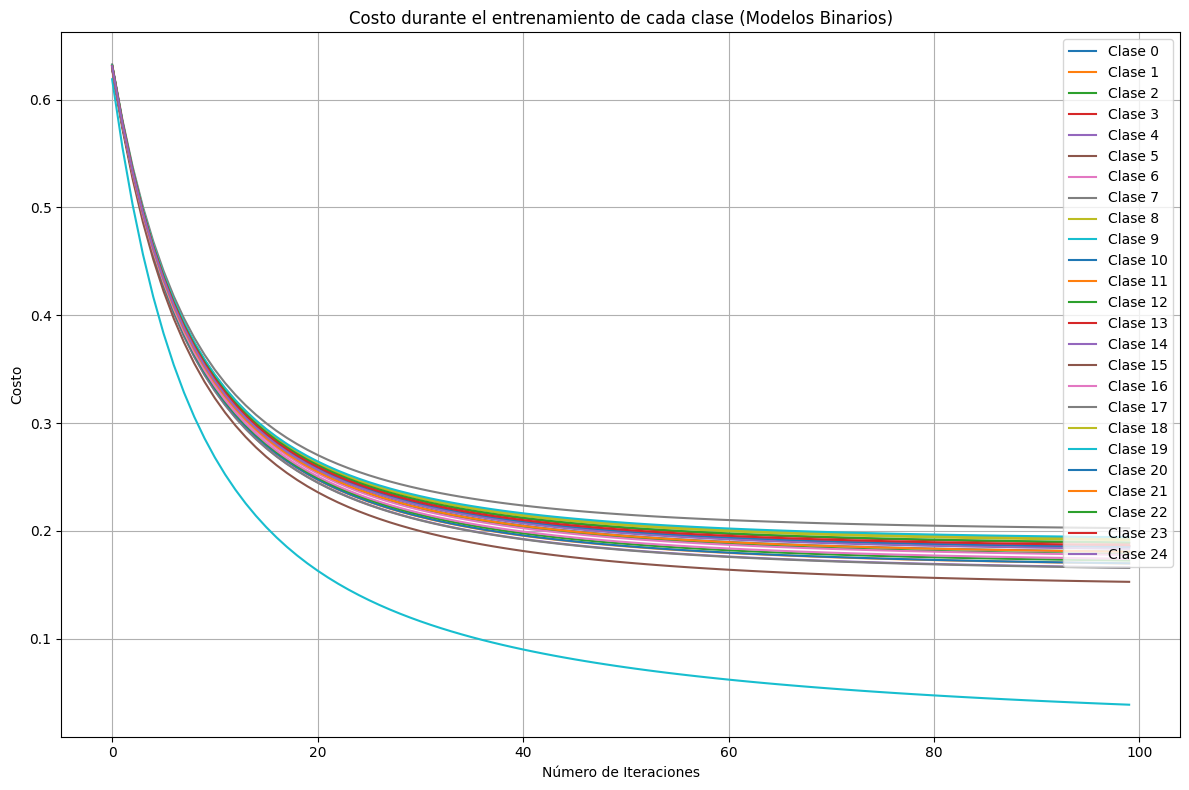

In [19]:
# Graficar todos los costos en un solo gráfico
plt.figure(figsize=(12, 8))
for clase in range(num_labels):
    plt.plot(np.arange(num_iters), costos_por_clase[clase], label=f'Clase {clase}')
plt.xlabel('Número de Iteraciones')
plt.ylabel('Costo')
plt.title('Costo durante el entrenamiento de cada clase (Modelos Binarios)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
# Función para graficar los costos
def plot_cost(cost_histories):
    plt.figure(figsize=(12, 8))
    for i in range(num_labels):
        plt.plot(cost_histories[i], label=f'Clase {i}')
    plt.xlabel('Número de iteraciones')
    plt.ylabel('Costo')
    plt.title('Costo durante la optimización para cada clase')
    plt.legend()
    plt.show()

#### 1.5.5 Predicciones

+ **Función predict_binary:** Realiza predicciones binarias utilizando los parámetros entrenados (theta) para cada clase. La predicción es 1 si la probabilidad es mayor o igual a 0.5, de lo contrario es 0.

+ **Función calculate_binary_accuracy:** Calcula la precisión para las predicciones binarias comparando las predicciones con las etiquetas verdaderas.

### 1.6 Modelo One_vs_all
También haremos uso de la función para graficar el costo.

+ **cost_histories:** Inicializa una lista de listas para almacenar el costo de la función de costo en cada iteración para cada clase.


In [21]:
def oneVsAll(X, y, num_labels, lambda_):
    m, n = X.shape
    all_theta = np.zeros((num_labels, n + 1))
    X = np.concatenate([np.ones((m, 1)), X], axis=1)  # Añadir columna de unos para el término de sesgo

    cost_histories = [[] for _ in range(num_labels)]  # Lista de listas para almacenar el costo por iteración para cada clase

    for c in range(num_labels):
        initial_theta = np.zeros(n + 1)
        options = {'maxiter': 300, 'disp': False}

        # Función callback para almacenar el costo en cada iteración
        def callback(theta):
            cost, _ = lrCostFunction(theta, X, (y == c), lambda_)
            cost_histories[c].append(cost)

        res = optimize.minimize(lrCostFunction,
                                initial_theta,
                                args=(X, (y == c), lambda_),
                                jac=True,
                                method='CG',
                                callback=callback,  # Usar el callback aquí
                                options=options)

        all_theta[c] = res.x

        # Imprimir el costo final para la clase actual
        final_cost = cost_histories[c][-1]
        print(f'Costo final para la clase {c}: {final_cost:.4f}')

    return all_theta, cost_histories

In [22]:
# Entrenamiento del modelo One-vs-All
all_theta, cost_histories  = oneVsAll(X_train, y_train, num_labels, lambda_)

Costo final para la clase 0: 0.0006
Costo final para la clase 1: 0.0006
Costo final para la clase 2: 0.0003
Costo final para la clase 3: 0.0020
Costo final para la clase 4: 0.0007
Costo final para la clase 5: 0.0019
Costo final para la clase 6: 0.0010
Costo final para la clase 7: 0.0008
Costo final para la clase 8: 0.0021
Costo final para la clase 9: 0.0000
Costo final para la clase 10: 0.0014
Costo final para la clase 11: 0.0017
Costo final para la clase 12: 0.0036
Costo final para la clase 13: 0.0025
Costo final para la clase 14: 0.0009
Costo final para la clase 15: 0.0006
Costo final para la clase 16: 0.0008
Costo final para la clase 17: 0.0122
Costo final para la clase 18: 0.0067
Costo final para la clase 19: 0.0026
Costo final para la clase 20: 0.0079
Costo final para la clase 21: 0.0100
Costo final para la clase 22: 0.0073
Costo final para la clase 23: 0.0024
Costo final para la clase 24: 0.0012


#### 1.6.1 Gráfica del costo
Llamamos a la función plotCost.

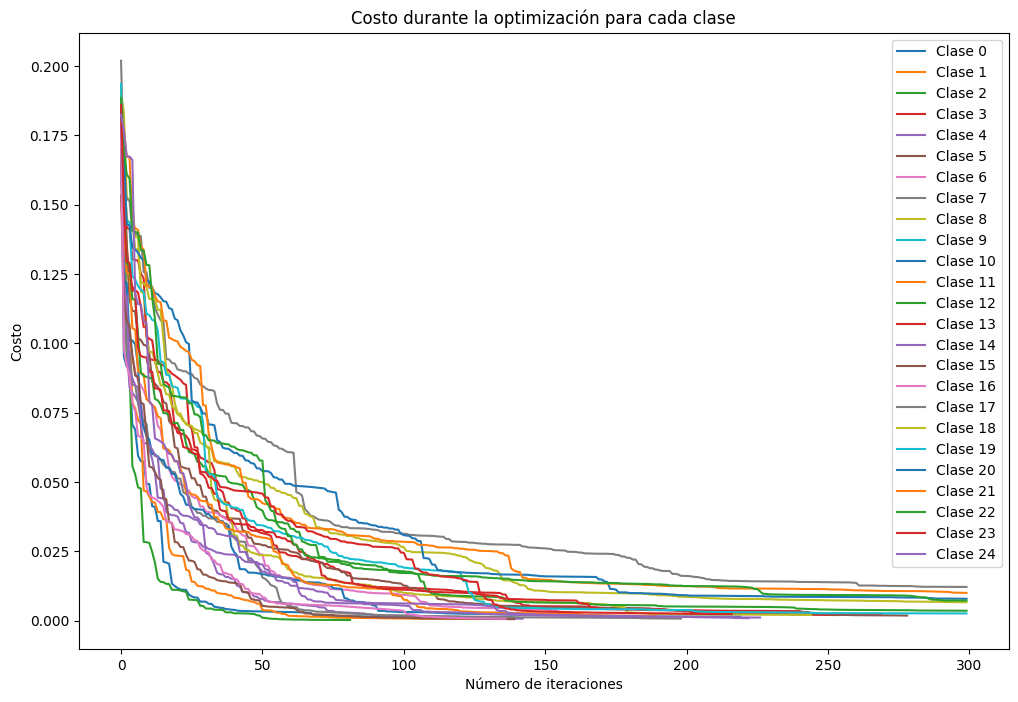

In [48]:
plot_cost(cost_histories)

#### 1.6.2 Predicciónn One-vs-all

Después de entrenar el clasificador de one-vs-all, se puede usarlo para predecir el dígito contenido en una imagen determinada. Para cada entrada, debe calcular la "probabilidad" de que pertenezca a cada clase utilizando los clasificadores de regresión logística entrenados.

In [24]:
def predictOneVsAll(all_theta, X):
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)  # Añadir columna de unos
    prob = sigmoid(X.dot(all_theta.T))
    return np.argmax(prob, axis=1)

Precisión de entrenamiento y prueba

In [53]:
pred_train = predictOneVsAll(all_theta, X_train)
print('Precision del conjuto de entrenamiento: {:.2f}%'.format(np.mean(pred_train == y_train) * 100))
print(f"Valor real: {(y_train[:10])}, \nPredicción: {(pred_train[:10])}\n")

pred_test = predictOneVsAll(all_theta, X_test)
print('Precision del conjuto de prueba: {:.2f}%'.format(np.mean(pred_test == y_test) * 100))
print(f"Valor real: {(y_test[:10])}, \nPredicción: {(pred_test[:10])}")

Precision del conjuto de entrenamiento: 99.92%
Valor real: [ 3  6  2  2 13 16  8 22  3  3], 
Predicción: [ 3  6  2  2 13 16  8 22  3  3]

Precision del conjuto de prueba: 98.58%
Valor real: [11 13 16  4  1 18  0 11  1  2], 
Predicción: [11 13 16  4  1 18  0 11  1  2]


#### 1.6.3 Predicción con Softmax
+ **Softmax:** La función softmax(z) calcula las probabilidades normalizadas para cada clase basada en los puntajes lineales (z). Esto asegura que las probabilidades sumen 1 y se puede interpretar directamente como la probabilidad de pertenencia a cada clase.

+ **Predicción con Softmax:** La función predict_softmax(X, all_theta) utiliza los parámetros theta entrenados para cada clase y calcula los puntajes para cada clase, aplicando Softmax para determinar la probabilidad y seleccionando la clase con la mayor probabilidad.

In [26]:
def softmax(z):
    exp_z = np.exp(z - np.max(z))  # Restar max(z) para estabilidad numérica
    return exp_z / exp_z.sum(axis=1, keepdims=True)

def predict_softmax(X, all_theta):
    # Añade una columna de 1
    X = np.c_[np.ones(X.shape[0]), X]
    # Calcula los puntajes para todas las clases usando theta de cada modelo
    z = X.dot(all_theta.T)
    # Aplica softmax para obtener las probabilidades
    probs = softmax(z)
    # Predice la clase con la probabilidad más alta
    return np.argmax(probs, axis=1)

Calculamos las predicciones y la precisión de la prueba

In [33]:
y_pred = predict_softmax(X_test, all_theta)
print(f"Valor real: {(y_test[:10])}, \nPredicción: {(y_pred[:10])}")

# Calcular la precisión del entrenamiento
accuracy = np.mean(y_pred == y_test) * 100
print(f"Precisión del entrenamiento usando Softmax: {accuracy:.2f}%")

Valor real: [11 13 16  4  1 18  0 11  1  2], 
Predicción: [11 13 16  4  1 18  0 11  1  2]
Precisión del entrenamiento usando Softmax: 98.58%
